In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
Tue Feb 13 14:34:19 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   43C    P0    67W / 275W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[14:34:22.463] INFO   CaloQVAE                                          Willkommen!
[14:34:22.463] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[14:34:22.978] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[14:34:22.978] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[14:34:22.979] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2024-02-13 14:34:23,389 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[14:34:23.389] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [15]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [16]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[14:40:43.404] INFO   data.dataManager                                  Loading Data
[14:40:48.746] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c90a45410>: 80000 events, 625 batches
[14:40:48.747] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c90a1a710>: 10000 events, 10 batches
[14:40:48.748] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c90970b50>: 10000 events, 10 batches
[14:40:50.960] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2024-02-13 14:40:50

Initializing NetworkV3


In [17]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[14:40:54.839] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[14:40:54.840] INFO   wandb                                             Watching
[14:40:54.842] INFO   engine.engineAtlas                                Setting up engine Atlas.
[14:40:54.843] INFO   engine.engineCaloV3                               Setting up engine Calo.
[14:40:54.843] INFO   engine.engine                                     Setting up default engine.


In [18]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[14:41:00.625] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c61c8f850>: 80000 events, 625 batches
[14:41:00.626] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c61c8f2d0>: 10000 events, 10 batches
[14:41:00.626] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f7c90915c10>: 10000 events, 10 batches


In [11]:
###LOAD MODEL

In [12]:
_epoch = 0
if config.load_state:
    print("Loading model...")
    assert config.run_path != 0
    config_string = "_".join(str(i) for i in [config.model.model_type, config.data.data_type, config.tag])
    modelCreator.load_state(config.run_path, dev)
    # _epoch = get_epochs(config.run_path)
    # temp solution to get total number of epochs this model has been trained on
    # fn = create_filenames_dict(config.run_path)
    # _epoch = fn["size"]
    # if config.freeze_vae:
    #     for name, param in engine.model.named_parameters():
    #         if 'decoder' in name or 'encoder' in name:
    #             param.requires_grad = False
    #         print(name, param.requires_grad)
    #     engine.optimiser = torch.optim.Adam(filter(lambda p: p.requires_grad, engine.model.parameters()), lr=config.engine.learning_rate)

In [ ]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])
                    
                    
def load_RBM_state(run_path, device):
        logger.info("Loading RBM state")
        model_loc = run_path
        # Load the dictionary with all tensors mapped to the CPU
        loaded_dict = torch.load(model_loc, map_location=device)
        return loaded_dict
    
# ww = load_RBM_state("/home/javier/Projects/CaloQVAE/outputs/2023-11-20/16-54-48/wandb/latest-run/files/RBM_1_0_weights.pth", dev)

In [47]:
150*0.3*0.3

13.5

In [189]:
##############

# happy-sun-270 | CNN + voxel pos enc + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'happy-sun-270'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231224_160705-n9y23yq6/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True

    
# drawn-cosmos-266 | CNN + cond + scaled data
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'drawn-cosmos-266'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  
    


# # misty-wind-267 | CNN + voxel pos enc JQTM + cond + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'misty-wind-267'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-37-11/wandb/run-20231224_164009-ti1793rl/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    

    
# # winter-glade-268 | CNN + cond pos enc + scaled data
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'winter-glade-268'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-39-27/wandb/run-20231224_163406-p7awkxhk/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    


# # prime-totem-282 | CNN + voxel pos enc + cond + scaled data
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
# modelname = 'prime-totem-282'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-01-08/13-51-41/wandb/run-20240108_135142-2fitsjre/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True  



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[18:55:16.762] INFO   models.modelCreator                               Loading state
[18:55:16.839] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2023-12-01/17-24-05/wandb/run-20231224_163015-m4f4z37z/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth


GumBoltAtlasPRBMCNN
electron-ds2
True False
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [72]:
# honest-blaze-275 | CNN + pions + scaled
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-01/20-38-58/wandb/run-20231201_203858-n9y23yq6/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth"
modelname = 'honest-blaze-275'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True  



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[14:34:36.861] INFO   models.modelCreator                               Loading state


GumBoltAtlasPRBMCNN
pion1
True False


[14:34:37.084] INFO   models.modelCreator                               Loading weights from file : /home/javier/Projects/CaloQVAE/outputs/2023-12-11/15-03-26/wandb/run-20231211_150327-vljzh7n3/files/GumBoltAtlasPRBMCNN_atlas_default_latest.pth


Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [11]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [12]:
##############################

In [190]:

partition_size=config.model.n_latent_nodes

energy_encoded_data = []

engine.model.eval()

with torch.no_grad():
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )

        energy_encoded_data.append(post_samples_energy.detach().cpu())

energy_encoded_data = torch.cat(energy_encoded_data, dim=0)

p1,p2,p3,p4 = post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], \
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size]

energy_rbm_data = []
with torch.no_grad():
    for i in range(10):
        # if i == 0:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0)
        # else:
            # p1, p2, p3, p4 = engine.model.stater.block_gibbs_sampling_ais(1.0, p1, p2, p3, p4)
        p1, p2, p3, p4 = engine.model.sampler.block_gibbs_sampling()
        rbm_samples_energy = engine.model.stater.energy_samples(p1, p2, p3, p4, 1.0)
        energy_rbm_data.append(rbm_samples_energy.detach().cpu())
    
energy_rbm_data = torch.cat(energy_rbm_data, dim=0)

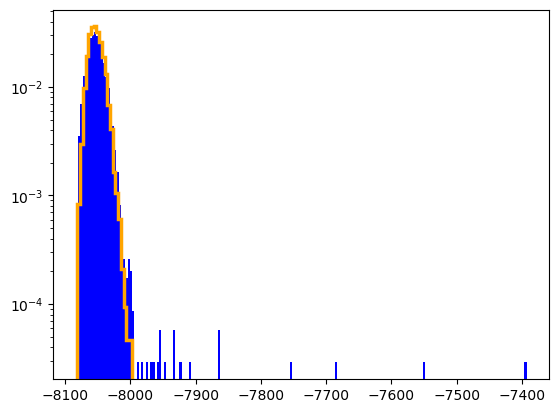

In [191]:
plt.hist(energy_encoded_data.numpy(), bins=200, linewidth=2.5, color="b", density=True, log=True)
plt.hist(energy_rbm_data.numpy(), bins=20, color="orange", density=True, fc=(1, 0, 1, 0.5), log=True, histtype='step', linewidth=2.5)
plt.show()

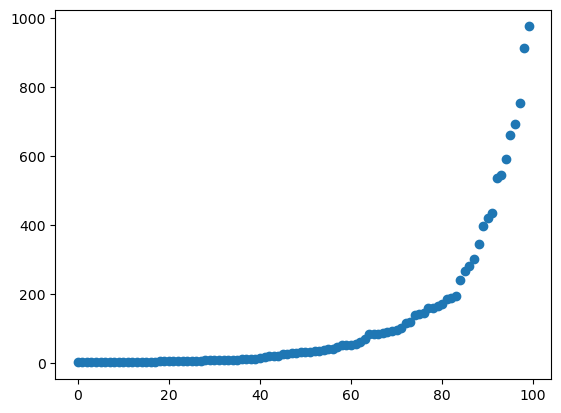

In [16]:
energy_list_subset = val_loader.__dict__['dataset'].__dict__['_true_energies'].reshape(-1)[0:100]/1000
plt.scatter(range(100), np.sort(energy_list_subset))

In [25]:
energy_encoded_data_per_energy.mean()

tensor(-3919.0063)

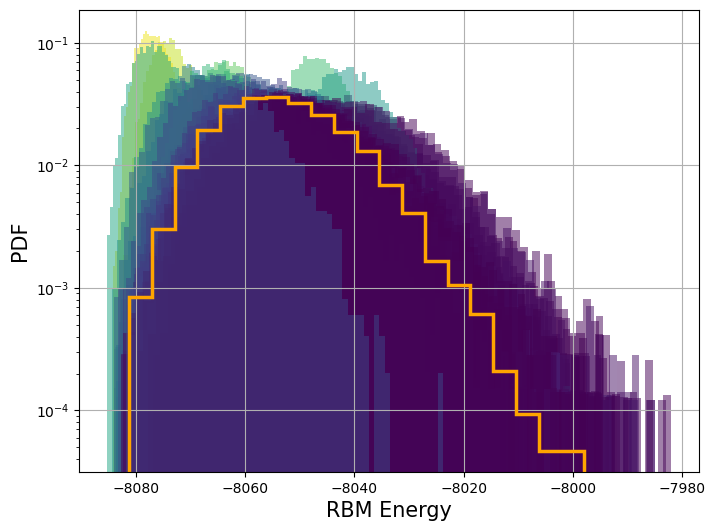

In [192]:
# ind = 10
sample_size = 1024
partition_size = config.model.n_latent_nodes
cmap = plt.cm.viridis

mean_rbm_energy = np.array([[0,0,0]])

plt.figure(figsize=(8,6))
for ind in range(0,106):
    en_ind = torch.Tensor([[val_loader.__dict__['dataset'].__dict__['_true_energies'].reshape(-1)[ind]]]).repeat(sample_size, 1)
    x_ind = val_loader.__dict__['dataset'].__dict__['_images']['showers'].__dict__['_image'][ind].unsqueeze(0).repeat(sample_size, 1)
    
    energy_encoded_data_per_energy = []
    for i in range(5):
        beta, post_logits, post_samples = engine.model.encoder(x_ind.to(dev), en_ind.to(dev), False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                         post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )

        energy_encoded_data_per_energy.append(post_samples_energy.detach().cpu())
    energy_encoded_data_per_energy = torch.cat(energy_encoded_data_per_energy, dim=0)
    
    mean_rbm_energy = np.concatenate((mean_rbm_energy, np.array([[energy_encoded_data_per_energy.mean(), en_ind[0].item(), energy_encoded_data_per_energy.std()]])), axis=0)
    
    lbl = np.round(en_ind[0].item()/1000,2)
    plt.hist(energy_encoded_data_per_energy.numpy(), color=cmap(lbl/1000), bins=60, linewidth=2.5, density=True, label=f'{lbl} GeV', log=True, alpha=0.5) 

plt.hist(energy_rbm_data.numpy(), bins=20, color="orange", density=True, fc=(1, 0, 1, 0.5), log=True, histtype='step', linewidth=2.5)
# plt.legend()
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid("True")
plt.show()
    

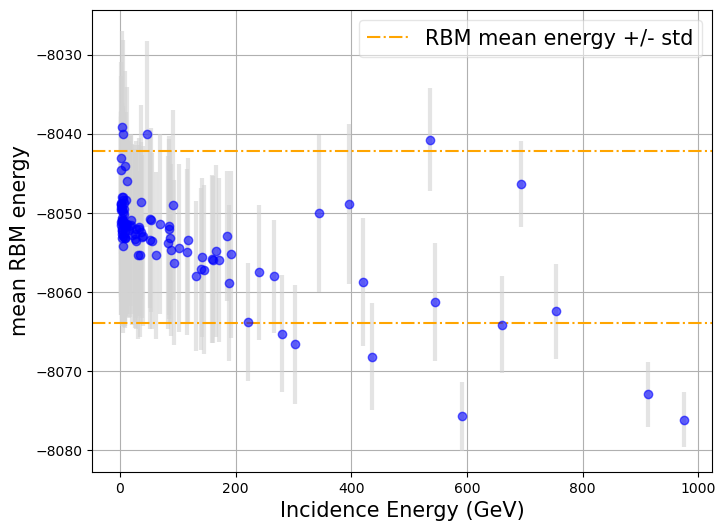

In [193]:
plt.figure(figsize=(8,6))
plt.errorbar(mean_rbm_energy[1:,1]/1000, mean_rbm_energy[1:,0], yerr=mean_rbm_energy[1:,2], fmt='o', ecolor='lightgray', elinewidth=3, capsize=0, alpha=0.6, color="blue")
# plt.scatter(mean_rbm_energy[1:,1]/1000, mean_rbm_energy[1:,0], marker='o', alpha=1, color="blue")
plt.axhline(energy_rbm_data.numpy().std() + energy_rbm_data.numpy().mean(), label="RBM mean energy +/- std", linestyle="dashdot", color='orange')
plt.axhline(-energy_rbm_data.numpy().std() + energy_rbm_data.numpy().mean(), linestyle="dashdot", color='orange')
plt.grid(True)
plt.xlabel("Incidence Energy (GeV)", fontsize=15)
plt.ylabel("mean RBM energy", fontsize=15)
plt.legend(framealpha=0.5, fontsize=15)
plt.show()

In [158]:
def error_btwn_input_and_recon_with_different_label(ind, start=3, stop=6, num=50):
    # ind = 2

    en_ind = torch.Tensor([[val_loader.__dict__['dataset'].__dict__['_true_energies'].reshape(-1)[ind]]]).repeat(sample_size, 1)
    x_ind = val_loader.__dict__['dataset'].__dict__['_images']['showers'].__dict__['_image'][ind].unsqueeze(0).repeat(sample_size, 1)
    in_data = torch.tensor(engine._data_mgr.inv_transform(x_ind.detach().cpu().numpy()))

    log_space_values = np.logspace(start=start, stop=stop, num=num, base=10)

    with torch.no_grad():
        beta, post_logits, post_samples = engine.model.encoder(x_ind.to(dev), en_ind.to(dev), False)
        post_samples = torch.cat(post_samples, 1)

        er_m_list = []
        er_std_list = []
        
        sp_er_m_list = []
        sp_er_std_list = []
        for en_prime in log_space_values:
            en_ind_prime = torch.Tensor([[en_prime]]).repeat(sample_size, 1)
            output_hits, output_activations = engine.model.decoder(post_samples, en_ind_prime.to(dev))
            beta = torch.tensor(engine.model._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)

            output_activations = engine.model._inference_energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, True)

            er = torch.pow(output_activations.sum(dim=1) - x_ind.to(dev).sum(dim=1), 2) #.cpu().numpy()
            er_m_list.append(er.mean().item()/1000)
            er_std_list.append(er.std().item()/1000)
            
            # spar_er = (((x_ind.to(dev).sign()==0).sum(dim=1)/x_ind.to(dev).shape[1] - (output_activations.sign()==0).sum(dim=1)/output_activations.shape[1])/((x_ind.to(dev).sign()==0).sum(dim=1)/x_ind.to(dev).shape[1] + 1)).cpu().numpy()
            # spar_er = (((x_ind.to(dev).sign()==0).sum(dim=1) / (output_activations.sign()==0).sum(dim=1))).cpu().numpy()
            spar_er = ((x_ind.to(dev).sign() - output_activations.sign()).abs().sum(dim=1)) #.cpu().numpy()
            sp_er_m_list.append(spar_er.mean().item())
            sp_er_std_list.append(spar_er.std().item())
            
    return er_m_list, er_std_list, log_space_values, en_ind[0].item(), in_data.sum(dim=1)[0].item(), sp_er_m_list, sp_er_std_list

In [159]:
# log_space_values[np.argmin(er_m_list)]
# (in_data.sign() - in_data.sign()).abs().sum(dim=1)

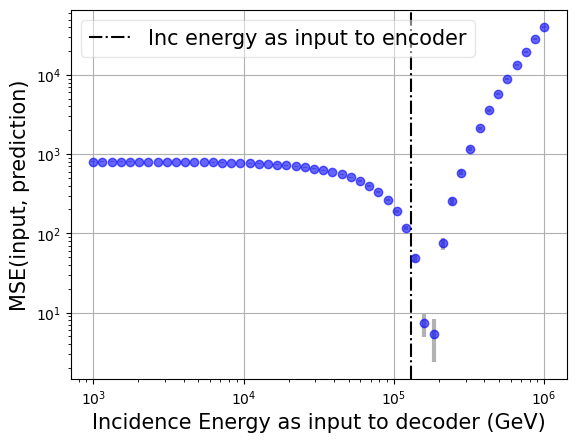

In [194]:
er_m_list, er_std_list, log_space_values, en_inc, shower_sum_in, sp_er_m_list, sp_er_std_list = error_btwn_input_and_recon_with_different_label(100, num=50)

plt.errorbar(log_space_values, er_m_list, yerr=er_std_list, fmt='o', ecolor='gray', elinewidth=3, capsize=0, alpha=0.6, color="blue")
plt.xscale("log")
plt.yscale("log")
plt.axvline(en_inc, label="Inc energy as input to encoder", linestyle="dashdot", color='black')
# plt.axvline(shower_sum_in, c='r')
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("MSE(input, prediction)", fontsize=15)
plt.legend(framealpha=0.5, fontsize=15)
plt.show()

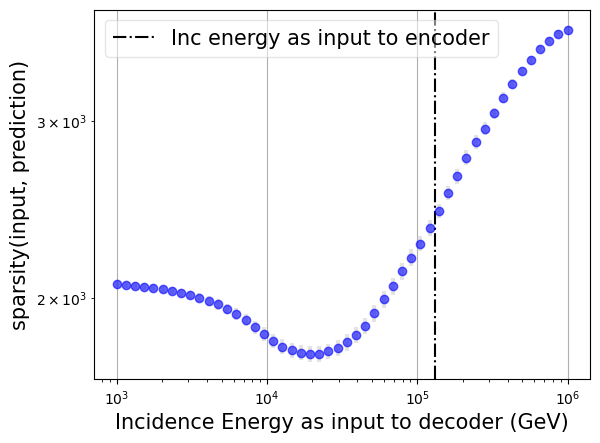

In [195]:
plt.errorbar(log_space_values, sp_er_m_list, yerr=sp_er_std_list, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0, alpha=0.6, color='blue')
plt.xscale("log")
plt.yscale("log")
plt.axvline(en_inc, label="Inc energy as input to encoder", linestyle="dashdot", color='black')
# plt.axvline(shower_sum_in, c='r')
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("sparsity(input, prediction)", fontsize=15)
plt.legend(framealpha=0.5, fontsize=15)
plt.show()

In [180]:
res_ar = torch.tensor([[0,0,0,0]])
torch.cat([res_ar, res_ar], dim=0)

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]])

In [196]:
res_ar = torch.tensor([[0,0,0,0]])
# res_ar = np.array([[0,0,0,0]])

for i in range(200):
    # print(i)
    er_m_list, er_std_list, log_space_values, en_inc, shower_sum_in, sp_er_m_list, sp_er_std_list = error_btwn_input_and_recon_with_different_label(i, num=50)

    energy_label_min = log_space_values[torch.tensor(er_m_list).argmin().item()]
    energy_label_min_spar = log_space_values[torch.tensor(sp_er_m_list).argmin().item()]
    # res_ar = np.concatenate((res_ar, np.array([[energy_label_min, en_inc, shower_sum_in, energy_label_min_spar]])), axis=0)
    res_ar = torch.cat([res_ar, torch.tensor([[energy_label_min, en_inc, shower_sum_in, energy_label_min_spar]])], dim=0)

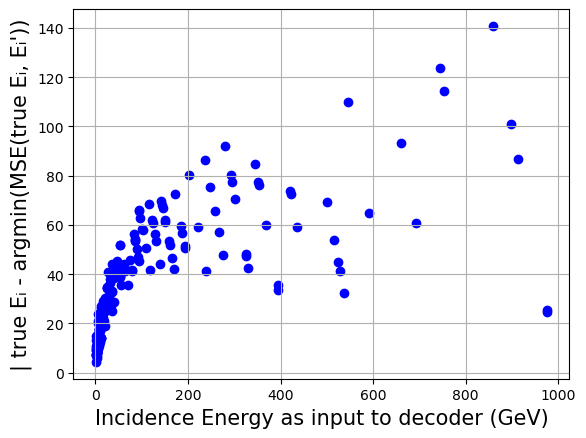

In [171]:
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,0] - res_ar[1:,1])/1000, color='b')
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("| true Eᵢ - argmin(MSE(true Eᵢ, Eᵢ'))", fontsize=15)
# plt.legend(framealpha=0.5, fontsize=15)
plt.show()

In [172]:
# m,b = np.polyfit(np.log(res_ar[1:,2]/1000), np.log((res_ar[1:,0] - res_ar[1:,2])/res_ar[1:,2]), 1)

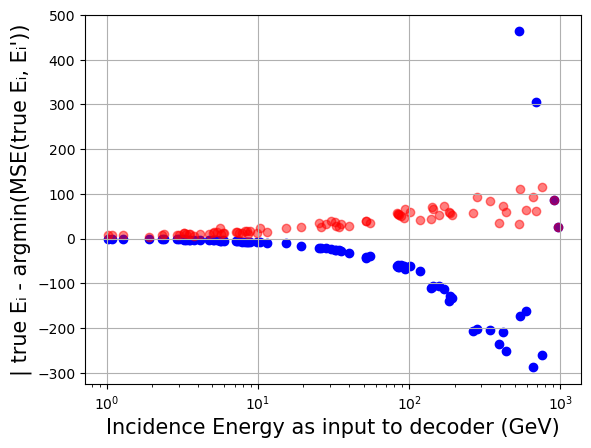

In [188]:
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,3] - res_ar[1:,1])/1000, color='b')
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,0] - res_ar[1:,1])/1000, color='red', alpha=0.5)
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("| true Eᵢ - argmin(MSE(true Eᵢ, Eᵢ'))", fontsize=15)
# plt.legend(framealpha=0.5, fontsize=15)
plt.xscale("log")
plt.show()

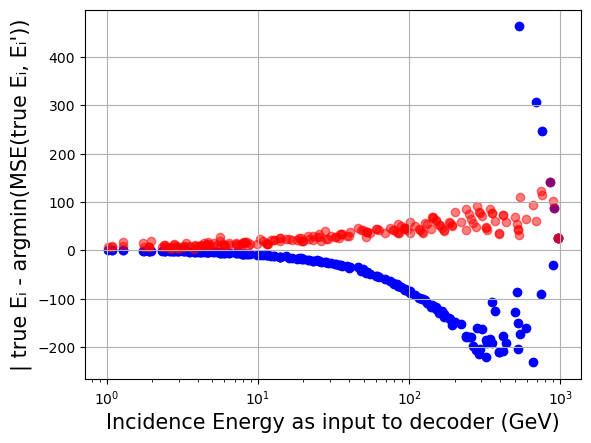

In [197]:
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,3] - res_ar[1:,1])/1000, color='b')
plt.scatter(res_ar[1:,1]/1000, (res_ar[1:,0] - res_ar[1:,1])/1000, color='red', alpha=0.5)
plt.grid(True)
plt.xlabel("Incidence Energy as input to decoder (GeV)", fontsize=15)
plt.ylabel("| true Eᵢ - argmin(MSE(true Eᵢ, Eᵢ'))", fontsize=15)
# plt.legend(framealpha=0.5, fontsize=15)
plt.xscale("log")
plt.show()